# DSC 630 - Predictive Analytics
# Term Project - Summer 2024
# David Berberena | Brian Mann

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning

## Milestone 3 - Preliminary Analysis

In [3]:
# dataset
url = 'https://www.kaggle.com/datasets/mrsimple07/restaurants-revenue-prediction'

### Step 1: Reading and Describing the Data

In [4]:
# reazd in the data and show the first few rows
df = pd.read_csv('restaurant_revenue.csv')
df.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


In [5]:
# get the size and shape
df.shape

(1000, 8)

In [6]:
# check for missing values
df.isna().sum()

Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64

In [7]:
# assess common stats for numerical variables
df.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,0.497000,49.837000,268.724172
std,26.364914,11.278760,5.845586,11.471686,0.500241,29.226334,103.982950
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-28.977809
25%,30.000000,20.396828,4.690724,19.603041,0.000000,24.000000,197.103642
50%,54.000000,30.860614,10.092047,29.251365,0.000000,50.000000,270.213964
75%,74.000000,39.843868,14.992436,39.553220,1.000000,76.000000,343.395793
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,563.381332


### Step 2: Histograms and Bar Charts

In [8]:
# this function takes in a df and a column and prints out a histogram
def make_histogram(data, col):
    sns.histplot(data[col], color='#f56c42')
    plt.title(f'Histogram of {col}')
    plt.show()

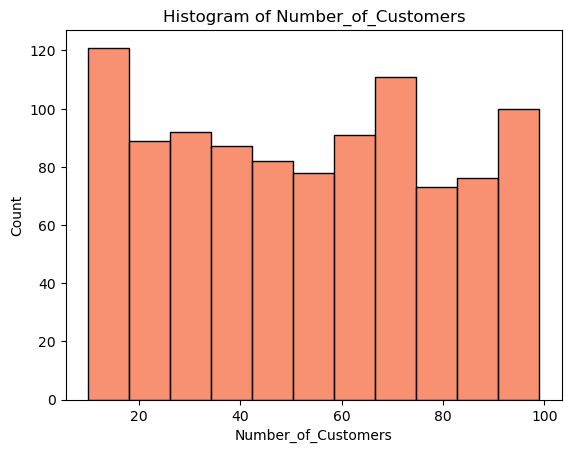

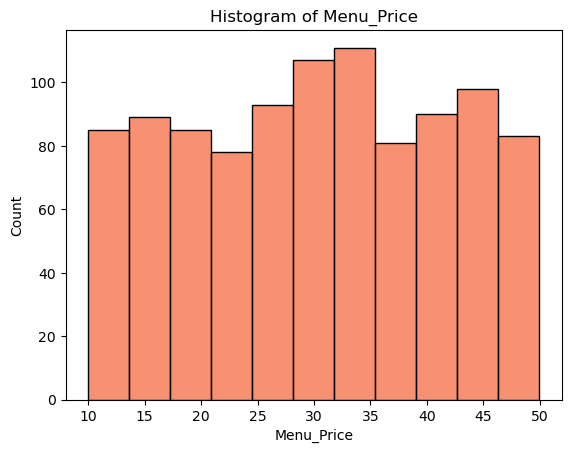

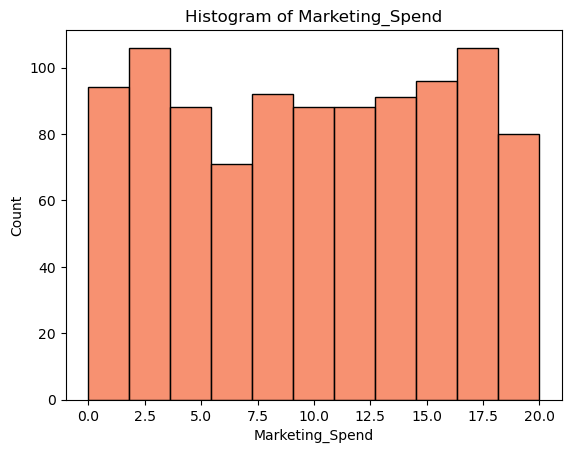

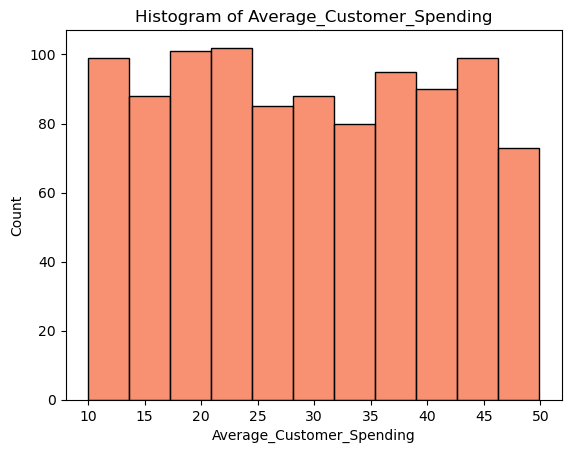

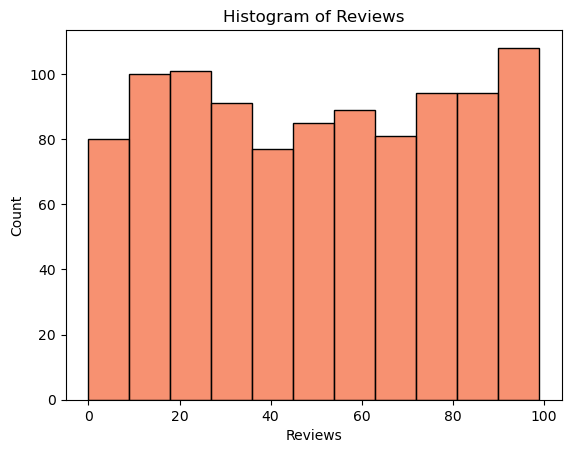

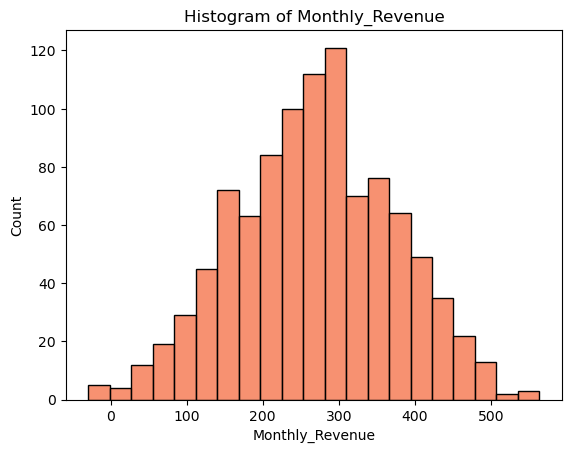

In [9]:
# print out histograms for each of the primary numerical variables
for col in df.describe().drop(columns='Promotions').columns:
    make_histogram(df, col)

In [10]:
# this function takes in a df and a column and prints out a horizontal bar 
# plot of the counts
def count_bar(data, col):
    counts = data[col].value_counts().reset_index()
    sns.barplot(data=counts, y=col, x='count', orient='h', palette='Set2')
    plt.title(f'Bar Plot of {col}')
    plt.show()

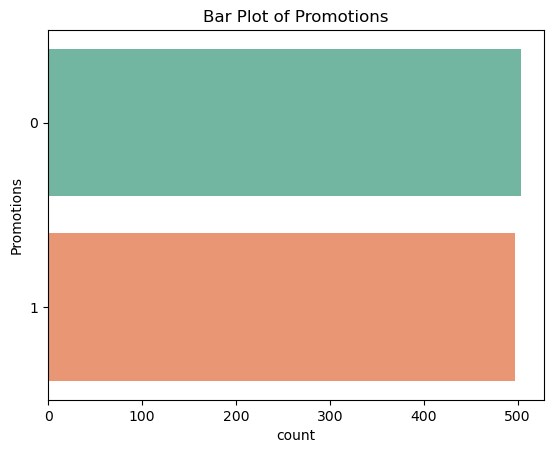

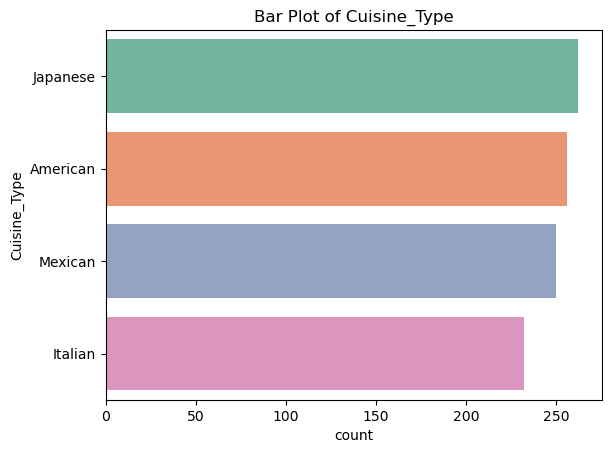

In [11]:
# print out bar plots for the counts of promotions and cusine type
for col in ['Promotions', 'Cuisine_Type']:
    count_bar(df, col)

## Step 3: Correlation and Scatterplots

In [12]:
# create dummy variables for cuisine type and make it its own df
dum = pd.get_dummies(df, columns=['Cuisine_Type'])
dum.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Cuisine_Type_American,Cuisine_Type_Italian,Cuisine_Type_Japanese,Cuisine_Type_Mexican
0,61,43.117635,12.663793,36.236133,0,45,350.912040,False,False,True,False
1,24,40.020077,4.577892,17.952562,0,36,221.319091,False,True,False,False
2,81,41.981485,4.652911,22.600420,1,91,326.529763,False,False,True,False
3,70,43.005307,4.416053,18.984098,1,59,348.190573,False,True,False,False
4,30,17.456199,3.475052,12.766143,1,30,185.009121,False,True,False,False


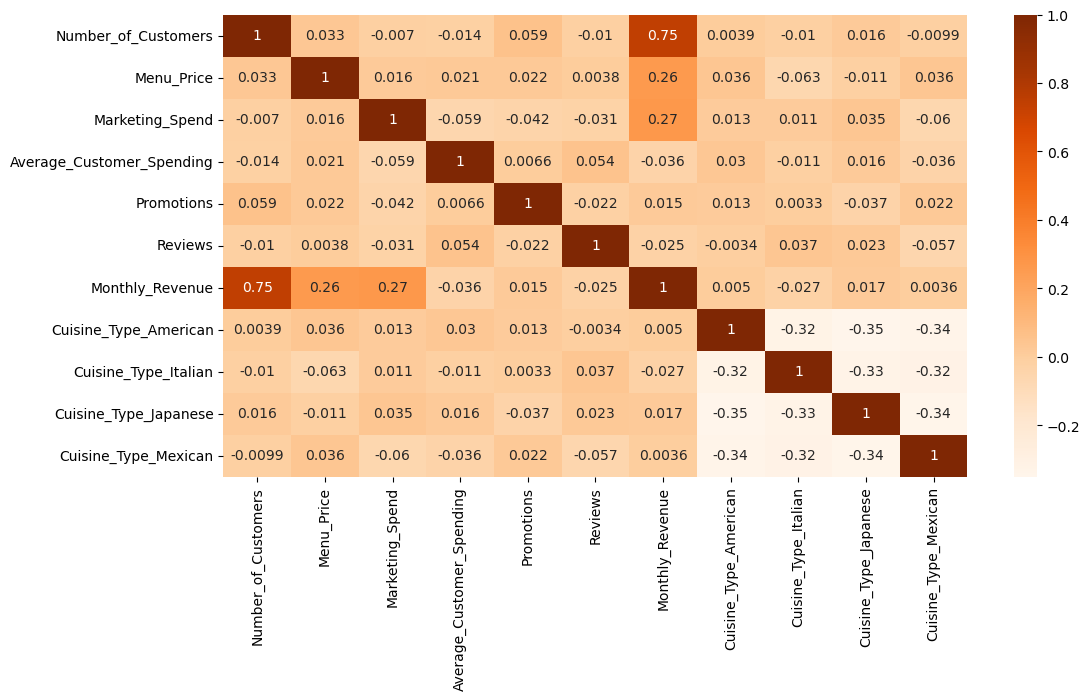

In [13]:
# find the correlation among all of the variales in the df
corrs = dum.corr()
plt.figure(figsize=(12,6))
# plot a heatmap of the correlations
sns.heatmap(corrs, cmap="Oranges", annot=True)
plt.show()

In [14]:
# this function takes in a df and two columns, then prints out a scatter plot 
# with a line of best fit containing margins of error
def scatter_with_fit(data, col1, col2):
    sns.lmplot(data=data, x=col1, y=col2, line_kws={'color': 'red'}, 
               scatter_kws={'color': '#79def7', 's': 5})
    plt.title(f'{col1} vs. {col2}')
    plt.show()

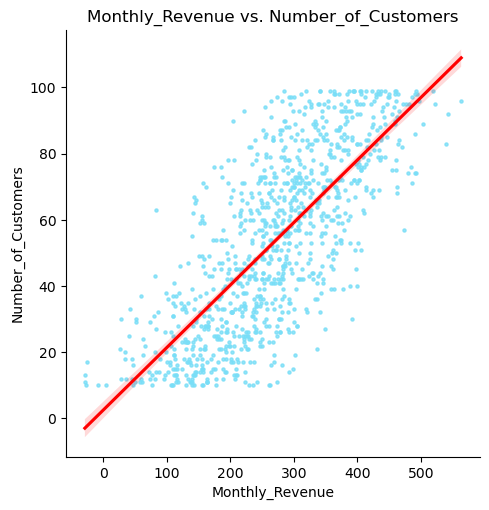

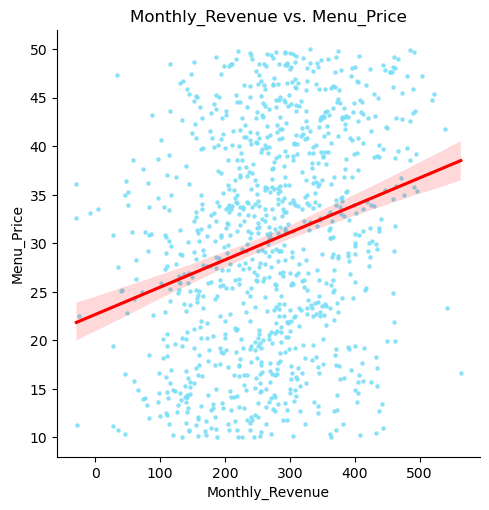

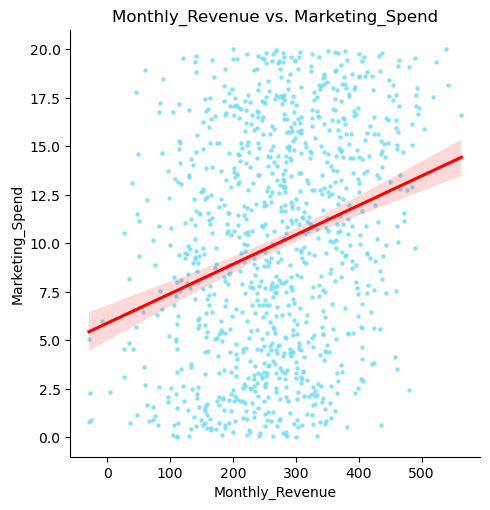

In [15]:
# print out scatterplots with best fine lines for the variables with 
# high correlations with monthly revenue
for col in ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend']:
    scatter_with_fit(df, 'Monthly_Revenue', col)

## Step 4: Grouping Revenue by Categories

In [16]:
# group cuisine types and promotions by average monthly revenue
types = df.groupby(by='Cuisine_Type').Monthly_Revenue.agg(np.mean).reset_index()
proms = df.groupby(by='Promotions').Monthly_Revenue.agg(np.mean).reset_index()

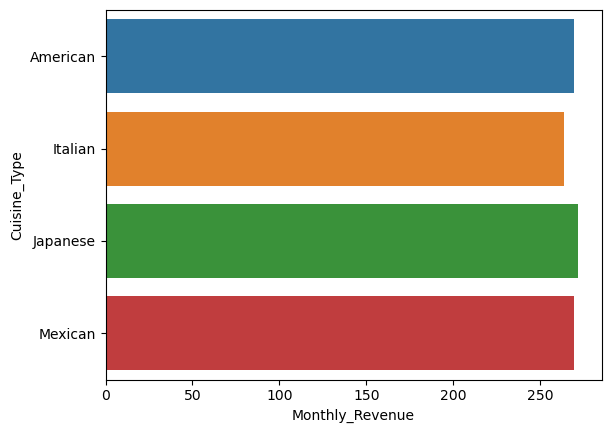

In [17]:
# print a barplot of revenue by cuisine type
sns.barplot(data=types, x='Monthly_Revenue', y='Cuisine_Type')
plt.show()

In [18]:
types

,Cuisine_Type,Monthly_Revenue
0,American,269.604825
1,Italian,263.699862
2,Japanese,271.700186
3,Mexican,269.366082


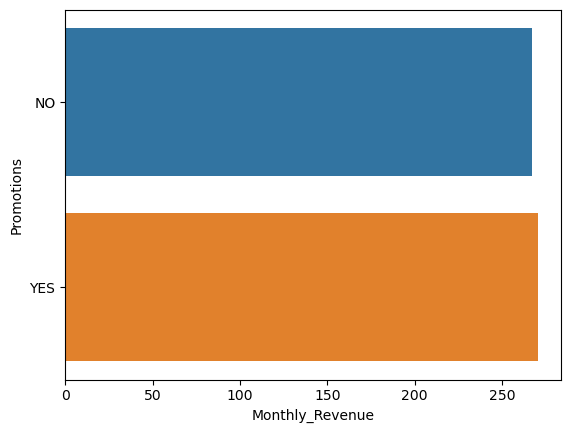

In [19]:
# rename the 0's to NO and the 1's to YES
proms.iloc[0,0] = 'NO'
proms.iloc[1,0] = 'YES'
# print a barplot of revenue by whether or not there was a promotion
sns.barplot(data=proms, x='Monthly_Revenue', y='Promotions')
plt.show()

In [20]:
proms

,Promotions,Monthly_Revenue
0,NO,267.188084
1,YES,270.278805


In [21]:
# Percent difference in aggregated monthly revenue for the presence of a promotional campaign 
# to establish the campaign's worth

print('%diff in aggregated monthly restaurant revenue with ' +
      'the presence of a promotional campaign: ', 
      ((proms['Monthly_Revenue'][1] / proms['Monthly_Revenue'][0]) - 1) * 100)

%diff in aggregated monthly restaurant revenue with the presence of a promotional campaign:  1.1567584291771071


## Step 5: Modeling

In [22]:
# get the dummy variables, while also dropping one of them 
dum = pd.get_dummies(df, columns=['Cuisine_Type'], drop_first=True)
# set the features to be all of the variables except monthly revenue
features = dum.drop(columns='Monthly_Revenue')
# split the data into training and testing sets at an 80/20 ratio
xtrain, xtest, ytrain, ytest = train_test_split(features, 
                                                dum['Monthly_Revenue'], test_size=0.2, random_state=1)

In [32]:
# Create a custom wrapper for statsmodels OLS
class OLSWrapper(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = None
        
    def fit(self, X, y):
        # Add a constant to the input features to account for the intercept
        X = sm.add_constant(X)
        self.model = sm.OLS(y, X).fit()
        print(self.model.summary())
        return self
    
    def predict(self, X):
        # Add a constant for prediction
        X = sm.add_constant(X)
        return self.model.predict(X)
    
    def score(self, X, y):
        predictions = self.predict(X)
        # Return R-squared score
        return 1 - np.sum((y - predictions) ** 2) / np.sum((y - np.mean(y)) ** 2)

# Create a pipeline with a custom wrapper
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', OLSWrapper())
])

# Set up a search space
search_space = [{'model': [OLSWrapper()]},
               {'model': [Ridge(max_iter=10000)], 
                'model__alpha': np.logspace(-4, 4, 50)}]

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, search_space, cv=5, scoring='r2')
gs = grid_search.fit(xtrain, ytrain)

be = gs.best_estimator_
print(f'Best estimator: {be}')
# make a prediction using the test data
pred = be.predict(xtest)
# get R^2 and RMSE
r2 = r2_score(ytest, pred)
rmse = np.sqrt(mean_squared_error(ytest, pred))
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")


                            OLS Regression Results                            
Dep. Variable:        Monthly_Revenue   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     148.7
Date:                Fri, 26 Jul 2024   Prob (F-statistic):          1.83e-149
Time:                        02:22:11   Log-Likelihood:                -3505.1
No. Observations:                 640   AIC:                             7030.
Df Residuals:                     630   BIC:                             7075.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        268.9217      2.305    116.692      0.0

Best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=7.9060432109076855, max_iter=10000))])
R^2: 0.6937014067272136
RMSE: 60.856889064989275


In [23]:
# create a pipeline for a scale and model
pipe = Pipeline([('scale', StandardScaler()), ('model', LinearRegression())])

In [24]:
# set up a search space for linear regression and ridge regression
search_space = [{'model': [LinearRegression()]},
               {'model': [Ridge(max_iter=10000)], 
                'model__alpha': np.logspace(-4, 4, 50)}]

In [25]:
# make a grid search cross-validation with 5-folds over the pipe and search space
grid_search = GridSearchCV(pipe, search_space, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

In [26]:
# this function takes in training and testing variables, fits 
# them to the grid search model, and prints out various results
def run_tests(x, xt, y, yt):
    # fit the training data to the grid search
    gs = grid_search.fit(x, y)
    # get the best estimator
    be = gs.best_estimator_
    print(f'Best estimator: {be}')
    # make a prediction using the test data
    pred = be.predict(xt)
    # get R^2 and RMSE
    r2 = r2_score(yt, pred)
    rmse = np.sqrt(mean_squared_error(yt, pred))
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    # print out the list of variables with their respective coefficients 
    coefs = be.named_steps['model'].coef_
    print("\nFeature importance:")
    for feature, coef in zip(features, coefs):
        print(f"{feature}: {coef:.4f}")

In [27]:
run_tests(xtrain, xtest, ytrain, ytest)

Best estimator: Pipeline(steps=[('scale', StandardScaler()),
                ('model', Ridge(alpha=7.9060432109076855, max_iter=10000))])
RMSE: 60.856889064989275
R^2: 0.6937014067272136

Feature importance:
Number_of_Customers: 74.5995
Menu_Price: 24.5487
Marketing_Spend: 26.0052
Average_Customer_Spending: -0.5611
Promotions: -3.5897
Reviews: -1.3689
Cuisine_Type_Italian: 0.4578
Cuisine_Type_Japanese: -0.6830
Cuisine_Type_Mexican: 0.2322


In [28]:
# this function runs a tree regression model on the data using a parameter grid 
def run_tree_regression():
    # set the initial state of the regressor
    tree_reg = DecisionTreeRegressor(random_state=1)
    # define a grid of potential parameters
    param_grid = {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    # create a grid search using 5 cross-folds on the tree regression model
    grid_search = GridSearchCV(estimator=tree_reg, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
    # apply the grid search to the training data
    grid_search.fit(xtrain, ytrain)
    # determine the best estimator
    be = grid_search.best_estimator_
    # use the best model to make predictions on the test data
    preds = be.predict(xtest)
    RMSE = np.sqrt(mean_squared_error(ytest, preds))
    R_sqaured = r2_score(ytest, preds)
    # print out the results of the best model's performance
    print(f'Best estimator: {be}')
    print(f'RMSE: {RMSE}')
    print(f'R^2: {R_sqaured}')

In [29]:
run_tree_regression()

Best estimator: DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=1)
RMSE: 77.33858179980125
R^2: 0.5053273330434154


In [33]:
# this function creates an ensemble model of ridge, tree, random forest and gradient boosting
# that applies a stacking regressor to the training data
def run_ensemble():
    # initialize each of the regression models
    ridge_reg = Ridge()
    tree_reg = DecisionTreeRegressor(random_state=1)
    rf_reg = RandomForestRegressor(random_state=1)
    gb_reg = GradientBoostingRegressor(random_state=1)
    # define the estimators for each model
    estimators = [
        ('ridge', ridge_reg),
        ('tree', tree_reg),
        ('rf', rf_reg),
        ('gb', gb_reg)
    ]
    # create a stack of models with a 5-fold cross-validation
    stacking_reg = StackingRegressor(
        estimators=estimators,
        cv=5
    )
    # fit the stack to the training data
    stacking_reg.fit(xtrain, ytrain)
    # use the fitted model to make predictions on the test data
    ypred_train = stacking_reg.predict(xtrain)
    ypred_test = stacking_reg.predict(xtest)
    # gather the assessment metrics
    rmse = np.sqrt(mean_squared_error(ytest, ypred_test))
    rsquared = r2_score(ytest, ypred_test)
    # print out the metrics
    print(f'RMSE: {rmse}')
    print(f'R^2: {rsquared}')

In [34]:
run_ensemble()

RMSE: 61.785734154105945
R^2: 0.6842801198816617
